In [1]:
# std
import os
import sys
import re

# 3rd party
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# get connected to the database
connection = pg.connect(user='scientist',
                        password='******',
                        host='127.0.01',
                        port='5432',
                        database='tensor_factorisation_fb15k_237')

In [3]:
entity = psql.read_sql("""SELECT DISTINCT subject FROM train UNION SELECT DISTINCT object FROM train
                          UNION SELECT DISTINCT subject FROM valid UNION SELECT DISTINCT object FROM valid
                          UNION SELECT DISTINCT subject FROM test UNION SELECT DISTINCT object FROM test
                        """, connection)
entity.head()

,subject
0,/m/02vqpx8
1,/m/016y3j
2,/m/0r2dp
3,/m/02ph9tm
4,/m/099d4


In [4]:
entity.count()

subject    14541
dtype: int64

In [5]:
entity_counts = entity.count().to_frame()
entity_counts.head()

,0
subject,14541


In [6]:
entity_counts = entity_counts.reset_index()
entity_counts.head()

,index,0
0,subject,14541


In [7]:
entity_counts = entity_counts.rename(columns={'index': 'label', 0: 'value'})
entity_counts.head()

,label,value
0,subject,14541


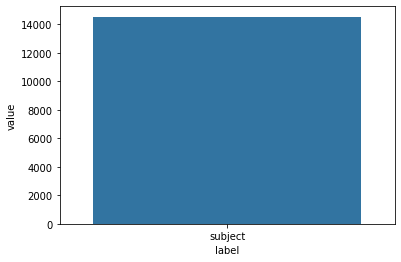

In [8]:
ax = sns.barplot(x="label", y="value", data=entity_counts)

In [9]:
relation = psql.read_sql("SELECT * FROM relation", connection)
relation.head()

,id,name
0,1,/base/petbreeds/city_with_dogs/top_breeds./bas...
1,2,/music/performance_role/track_performances./mu...
2,3,/people/profession/specialization_of
3,4,/music/performance_role/guest_performances./mu...
4,5,/film/film/release_date_s./film/film_regional_...


In [10]:
relation_counts = relation.count().to_frame()
relation_counts.head()

,0
id,237
name,237


In [11]:
relation_counts = relation_counts.reset_index()
relation_counts.head()

,index,0
0,id,237
1,name,237


In [12]:
relation_counts = relation_counts.rename(columns={'index': 'label', 0: 'value'})
relation_counts.head()

,label,value
0,id,237
1,name,237


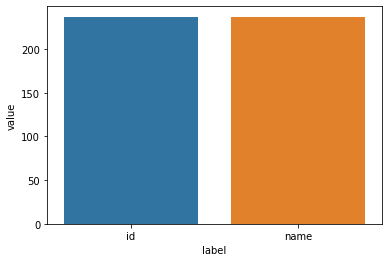

In [13]:
ax = sns.barplot(x="label", y="value", data=relation_counts)

In [14]:
triple = psql.read_sql("SELECT * FROM train UNION SELECT * FROM valid UNION SELECT * FROM test", connection)
triple.head()

,id,subject,predicate,object
0,1,/m/027rn,/location/country/form of government,/m/06cx9
1,1,/m/07pd_j,/film/film/genre,/m/02l7c8
2,1,/m/08966,/travel/travel destination/climate./travel/tra...,/m/05lf_
3,2,/m/017dcd,/tv/tv program/regular cast./tv/regular tv app...,/m/06v8s0
4,2,/m/01hww_,/music/performance role/regular performances./...,/m/01q99h


In [15]:
triple_counts = triple.count().to_frame()
triple_counts.head()

,0
id,310116
subject,310116
predicate,310116
object,310116


In [16]:
triple_counts = triple_counts.reset_index()
triple_counts.head()

,index,0
0,id,310116
1,subject,310116
2,predicate,310116
3,object,310116


In [17]:
triple_counts = triple_counts.rename(columns={'index': 'label', 0: 'value'})
triple_counts

,label,value
0,id,310116
1,subject,310116
2,predicate,310116
3,object,310116


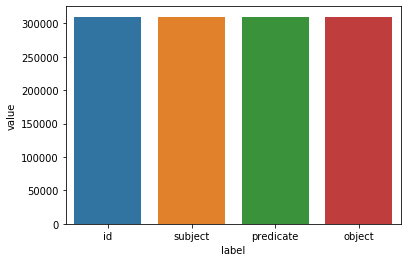

In [18]:
ax = sns.barplot(x="label", y="value", data=triple_counts)

In [19]:
triple_counts.loc[0, 'value']

310116

In [20]:
triple_count = pd.Series({'triple': triple_counts.loc[0, 'value']})
entity_count = pd.Series({'entity': entity_counts.loc[0, 'value']})
relation_count = pd.Series({'relation': relation_counts.loc[0, 'value']})

triple_entity_relation_counts = pd.DataFrame([triple_count, entity_count, relation_count])
triple_entity_relation_counts.head()

,triple,entity,relation
0,310116.0,NaN,NaN
1,NaN,14541.0,NaN
2,NaN,NaN,237.0


In [21]:
triple_entity_relation_counts = pd.DataFrame([triple_counts.loc[0, 'value'], 
                                              entity_counts.loc[0, 'value'], 
                                              relation_counts.loc[0, 'value']], index=['triple', 'entity', 'relation'])
triple_entity_relation_counts.head()

,0
triple,310116
entity,14541
relation,237


In [22]:
triple_entity_relation_counts = triple_entity_relation_counts.reset_index()
triple_entity_relation_counts.head()

,index,0
0,triple,310116
1,entity,14541
2,relation,237


In [23]:
triple_entity_relation_counts = triple_entity_relation_counts.rename(columns={'index': 'label', 0: 'value'})
triple_entity_relation_counts.head()

,label,value
0,triple,310116
1,entity,14541
2,relation,237


In [24]:
tmp = triple_entity_relation_counts.iloc[0]
triple_entity_relation_counts.iloc[0] = triple_entity_relation_counts.iloc[1]
triple_entity_relation_counts.iloc[1] = triple_entity_relation_counts.iloc[2]
triple_entity_relation_counts.iloc[2] = tmp
triple_entity_relation_counts

,label,value
0,entity,14541
1,relation,237
2,triple,310116


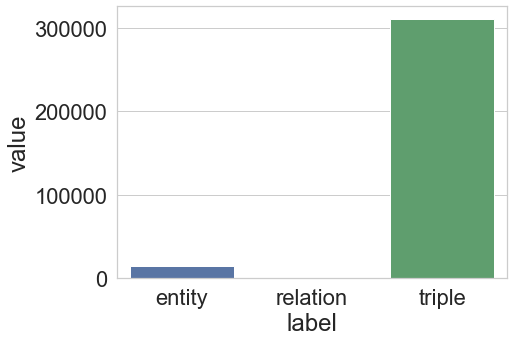

In [25]:
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid", font_scale=2) 
ax = sns.barplot(x="label", y="value", data=triple_entity_relation_counts)
plt.savefig('FB15k-237_Counts.png', bbox_inches = "tight", format='PNG')

In [26]:
fact = psql.read_sql("SELECT * FROM fact_train UNION SELECT * FROM fact_valid UNION SELECT * FROM fact_test", connection)
fact.head()

,id,subject,s_name,predicate,object,o_name
0,1,/m/027rn,Dominican Republic,/location/country/form of government,/m/06cx9,Republic
1,1,/m/07pd_j,American Pie (film),/film/film/genre,/m/02l7c8,Romance film
2,1,/m/08966,Zurich,/travel/travel destination/climate./travel/tra...,/m/05lf_,October
3,2,/m/017dcd,Mighty Morphin Power Rangers,/tv/tv program/regular cast./tv/regular tv app...,/m/06v8s0,Wendee Lee
4,2,/m/01hww_,Autoharp,/music/performance role/regular performances./...,/m/01q99h,Heart (band)


In [27]:
fact = fact.set_index('id')
fact.head()

,subject,s_name,predicate,object,o_name
id,,,,,
1,/m/027rn,Dominican Republic,/location/country/form of government,/m/06cx9,Republic
1,/m/07pd_j,American Pie (film),/film/film/genre,/m/02l7c8,Romance film
1,/m/08966,Zurich,/travel/travel destination/climate./travel/tra...,/m/05lf_,October
2,/m/017dcd,Mighty Morphin Power Rangers,/tv/tv program/regular cast./tv/regular tv app...,/m/06v8s0,Wendee Lee
2,/m/01hww_,Autoharp,/music/performance role/regular performances./...,/m/01q99h,Heart (band)


In [28]:
predicate_counts = fact['predicate'].value_counts(dropna=False)
predicate_counts.head(50)

/award/award nominee/award nominations./award/award nomination/award nominee                       16391
/film/film/release date s./film/film regional release date/film release region                     15568
/award/award nominee/award nominations./award/award nomination/award                               14051
/people/person/profession                                                                          13382
/award/award category/nominees./award/award nomination/nominated for                               11069
/film/actor/film./film/performance/film                                                            11045
/film/film/genre                                                                                    8649
/award/award winner/awards won./award/award honor/award winner                                      8491
/music/genre/artists                                                                                7134
/award/award nominee/award nominations./award/award nom

In [29]:
predicate_counts.index

Index(['/award/award nominee/award nominations./award/award nomination/award nominee',
       '/film/film/release date s./film/film regional release date/film release region',
       '/award/award nominee/award nominations./award/award nomination/award',
       '/people/person/profession',
       '/award/award category/nominees./award/award nomination/nominated for',
       '/film/actor/film./film/performance/film', '/film/film/genre',
       '/award/award winner/awards won./award/award honor/award winner',
       '/music/genre/artists',
       '/award/award nominee/award nominations./award/award nomination/nominated for',
       ...
       '/education/university/international tuition./measurement unit/dated money value/currency',
       '/base/localfood/seasonal month/produce available./base/localfood/produce availability/seasonal months',
       '/film/special film performance type/film performance type./film/performance/film',
       '/dataworld/gardening hint/split to', '/music/ins

In [30]:
predicate_counts = predicate_counts.reset_index()
predicate_counts.head(50)

,index,predicate
0,/award/award nominee/award nominations./award/...,16391
1,/film/film/release date s./film/film regional ...,15568
2,/award/award nominee/award nominations./award/...,14051
3,/people/person/profession,13382
4,/award/award category/nominees./award/award no...,11069
5,/film/actor/film./film/performance/film,11045
6,/film/film/genre,8649
7,/award/award winner/awards won./award/award ho...,8491
8,/music/genre/artists,7134
9,/award/award nominee/award nominations./award/...,6483


In [31]:
predicate_counts = predicate_counts.rename(columns={'index': 'label', 'predicate': 'value'})
predicate_counts.head()

,label,value
0,/award/award nominee/award nominations./award/...,16391
1,/film/film/release date s./film/film regional ...,15568
2,/award/award nominee/award nominations./award/...,14051
3,/people/person/profession,13382
4,/award/award category/nominees./award/award no...,11069


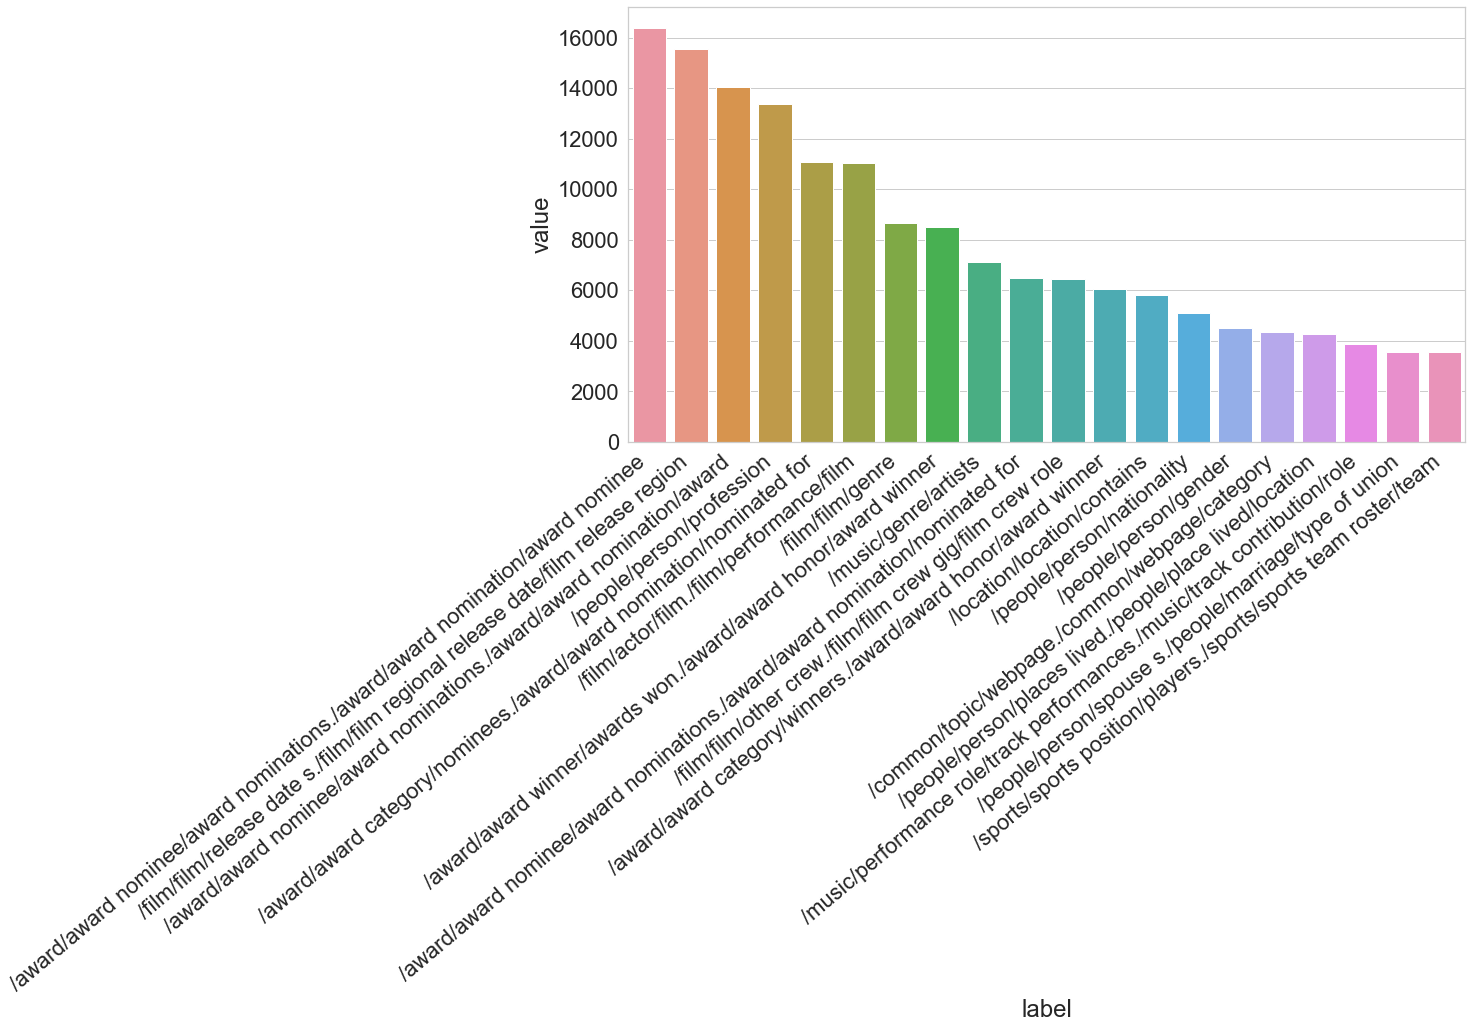

In [32]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid", font_scale=2) 
ax = sns.barplot(x="label", y="value", data=predicate_counts[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.savefig('FB15k-237_Predicate_Counts.png', bbox_inches = "tight", format='PNG')

In [33]:
predicate_counts.count(), predicate_counts.max(), predicate_counts.min(), predicate_counts.median()

(label    237
 value    237
 dtype: int64, label    /user/tsegaran/random/taxonomy subject/entry./...
 value                                                16391
 dtype: object, label    /american football/football team/current roste...
 value                                                   45
 dtype: object, value    426.0
 dtype: float64)

In [34]:
# Computing IQR
Q1 = predicate_counts.quantile(0.25)
Q3 = predicate_counts.quantile(0.75)
IQR = Q3 - Q1
IQR

value    819.0
dtype: float64

In [35]:
object_counts = fact['o_name'].value_counts(dropna=False).to_frame()
object_counts.head()

,o_name
United States,7124
United States dollar,4748
/m/08mbj5d,4364
Male,3567
Marriage,3162


In [36]:
fact.groupby(['object']).head()

,subject,s_name,predicate,object,o_name
id,,,,,
1,/m/027rn,Dominican Republic,/location/country/form of government,/m/06cx9,Republic
1,/m/07pd_j,American Pie (film),/film/film/genre,/m/02l7c8,Romance film
1,/m/08966,Zurich,/travel/travel destination/climate./travel/tra...,/m/05lf_,October
2,/m/017dcd,Mighty Morphin Power Rangers,/tv/tv program/regular cast./tv/regular tv app...,/m/06v8s0,Wendee Lee
2,/m/01hww_,Autoharp,/music/performance role/regular performances./...,/m/01q99h,Heart (band)
...,...,...,...,...,...
271911,/m/03kq98,Roots (TV miniseries),/tv/tv program/regular cast./tv/regular tv app...,/m/01p4r3,Lloyd Bridges
271926,/m/02sdk9v,Forward (association football),/sports/sports position/players./sports/sports...,/m/06ppc4,Altrincham F.C.
271989,/m/02rv1w,"California State University, Fullerton",/education/educational institution/students gr...,/m/04pg29,Marc Cherry


In [37]:
object_counts.index

Index(['United States', 'United States dollar', '/m/08mbj5d', 'Male',
       'Marriage', 'English language', 'Actor', 'DVD', 'United Kingdom',
       'Drama film',
       ...
       'Star Wars', 'Urban contemporary gospel', 'Sire Records', 'Premier',
       'Giovani dos Santos', 'Washington Metropolitan Area', 'Kader Khan',
       'Thiago Emiliano da Silva', 'Alex Manninger', 'LaGuardia Airport'],
      dtype='object', length=13504)

In [38]:
object_counts = object_counts.reset_index()
object_counts.head()

,index,o_name
0,United States,7124
1,United States dollar,4748
2,/m/08mbj5d,4364
3,Male,3567
4,Marriage,3162


In [39]:
object_counts = object_counts.rename(columns={'index': 'label', 'o_name': 'value'})
object_counts.head()

,label,value
0,United States,7124
1,United States dollar,4748
2,/m/08mbj5d,4364
3,Male,3567
4,Marriage,3162


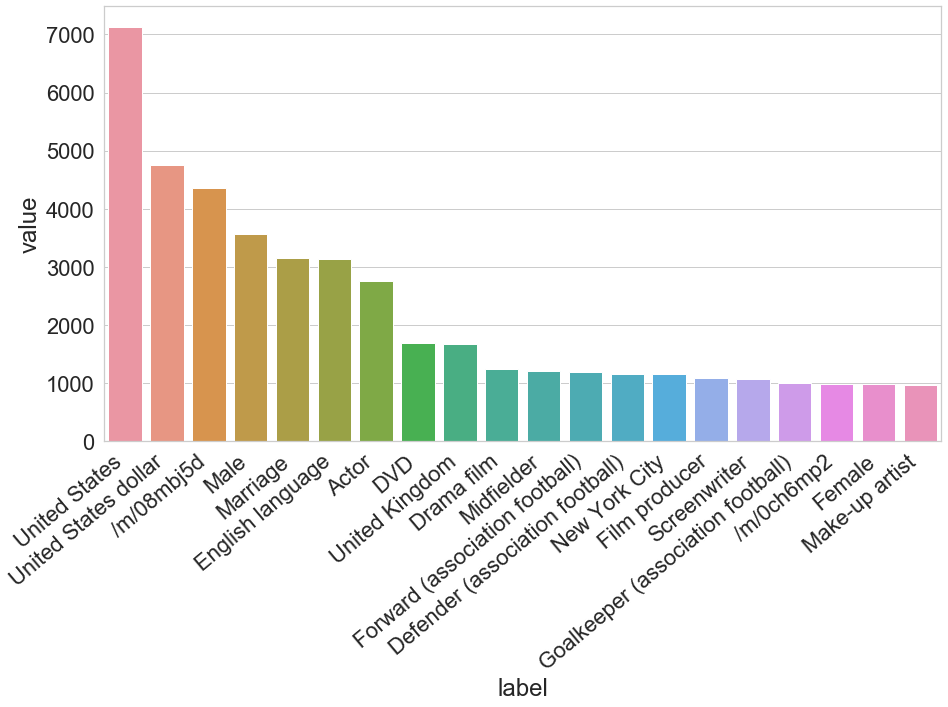

In [40]:
plt.figure(figsize=(15, 8))
sns.set(style='whitegrid', font_scale=2) 
ax = sns.barplot(x="label", y="value", data=object_counts[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.savefig('FB15k-237_Object_Counts.png', bbox_inches = "tight", format='PNG')

In [41]:
object_counts.count(), object_counts.max(), object_counts.min(), object_counts.median()

(label    13504
 value    13504
 dtype: int64, label    İzmir
 value     7124
 dtype: object, label    'N Sync
 value          1
 dtype: object, value    10.0
 dtype: float64)

In [42]:
# Computing IQR
Q1 = object_counts.quantile(0.25)
Q3 = object_counts.quantile(0.75)
IQR = Q3 - Q1
IQR

value    16.0
dtype: float64

In [43]:
subject_counts = fact['s_name'].value_counts().to_frame()
subject_counts.head()

,s_name
United States,1518
Guitar,754
President,723
Bachelor of Arts,622
Forward (association football),612


In [44]:
subject_counts.index

Index(['United States', 'Guitar', 'President', 'Bachelor of Arts',
       'Forward (association football)', 'Defender (association football)',
       'Midfielder', 'United Kingdom', 'Marriage', 'Piano',
       ...
       'The Kinks', 'Province of Salerno', 'Mogadishu', 'Psychic',
       'Windsor Castle', 'Xinjiang', 'United States Secretary of State',
       'St Andrews', 'Lake District', 'City of Halifax'],
      dtype='object', length=13891)

In [45]:
subject_counts = subject_counts.reset_index()
subject_counts.head()

,index,s_name
0,United States,1518
1,Guitar,754
2,President,723
3,Bachelor of Arts,622
4,Forward (association football),612


In [46]:
subject_counts = subject_counts.rename(columns={'index': 'label', 's_name': 'value'})
subject_counts.head()

,label,value
0,United States,1518
1,Guitar,754
2,President,723
3,Bachelor of Arts,622
4,Forward (association football),612


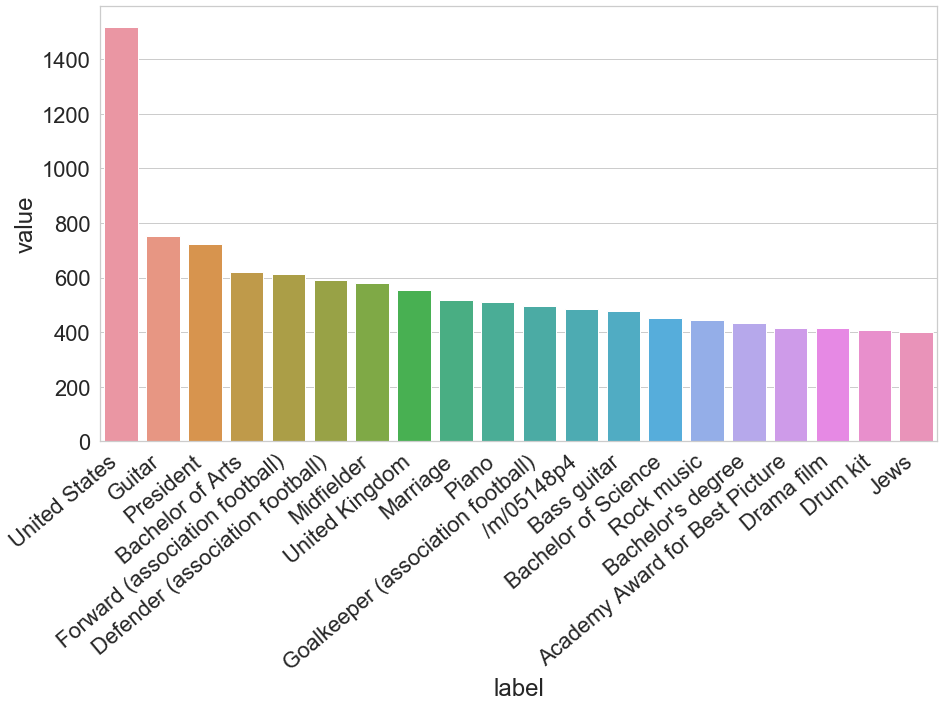

In [47]:
plt.figure(figsize=(15, 8))
sns.set(style='whitegrid', font_scale=2) 
ax = sns.barplot(x="label", y="value", data=subject_counts[:20])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.savefig('FB15k-237_Subject_Counts.png', bbox_inches = "tight", format='PNG')

In [48]:
subject_counts.count(), subject_counts.max(), subject_counts.min(), subject_counts.median()

(label    13891
 value    13891
 dtype: int64, label    İzmir
 value     1518
 dtype: object, label    'N Sync
 value          1
 dtype: object, value    16.0
 dtype: float64)

In [49]:
# Computing IQR
Q1 = subject_counts.quantile(0.25)
Q3 = subject_counts.quantile(0.75)
IQR = Q3 - Q1
IQR

value    20.0
dtype: float64